# NYC Taxi Fare Prediction



## Description of the problem
This project builds a machine-learning model capable of predicting the fare amount of a New York City taxi trip based on trip characteristics available at the moment of pickup. The model is designed to be used in a real-time API for fare estimation, following a production-ready MLOps workflow.

## Project Goal
Estimate the total taxi fare before the trip begins using features such as trip distance, pickup time, pickup/dropoff locations, and passenger count.

The model is intended for use with new unseen data, enabling applications like mobile apps, ride-hailing services, or pricing simulations.

## Data


The project uses the publicly available [NYC Yellow Taxi Trip Records dataset (2016)](https://www.kaggle.com/datasets/yasserh/uber-fares-dataset), which includes:

|Column|Descripcion|
|--|-----|
|key | a unique identifier for each trip|
|fare_amount | the cost of each trip in usd|
|pickup_datetime | date and time when the meter was engaged|
|passenger_count | the number of passengers in the vehicle (driver entered value)|
|pickup_longitude | the longitude where the meter was engaged|
|pickup_latitude | the latitude where the meter was engaged|
|dropoff_longitude | the longitude where the meter was disengaged|
|dropoff_latitude | the latitude where the meter was disengaged|

**Granularity:**
One row per trip


The dataset is already included in this repository. However it can be downloaded from Kagglehub following the instructions below. 


In [2]:
!pip install kagglehub[pandas-datasets]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [kagglehub]


In [23]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yasserh/uber-fares-dataset")

print("Path to dataset files:", path)

100%|████████████████████████████████████████████████████| 7.04M/7.04M [00:00<00:00, 61.5MB/s]

Extracting files...


Path to dataset files: /home/codespace/.cache/kagglehub/datasets/yasserh/uber-fares-dataset/versions/1


In [ ]:
import pandas as pd

In [ ]:
!ls /home/codespace/.cache/kagglehub/datasets/yasserh/uber-fares-dataset/versions/1

uber.csv


In [6]:
df = pd.read_csv("/home/codespace/.cache/kagglehub/datasets/yasserh/uber-fares-dataset/versions/1/uber.csv")

In [7]:
# Export locally 
df.to_csv("uber.csv.gz", index=False, compression='gzip')

## Data preparation and data cleaning

In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import display

In [4]:
df = pd.read_csv("uber.csv.gz", compression='gzip')

In [5]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [7]:
# Min, max, mean, etc.
df.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


In [8]:
# Check infinite values
np.isinf(df.select_dtypes(include=[np.number])).any() 

Unnamed: 0           False
fare_amount          False
pickup_longitude     False
pickup_latitude      False
dropoff_longitude    False
dropoff_latitude     False
passenger_count      False
dtype: bool

In [9]:
# Check null values
df.isna().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [10]:
cols=df.columns.tolist()
cols

['Unnamed: 0',
 'key',
 'fare_amount',
 'pickup_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count']

In [11]:
df = df[['fare_amount',
 'pickup_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count']]

#### Target Variable

fare_amount

## EDA 

### Target variable

Text(0.5, 1.0, 'Fare Amount Distribution')

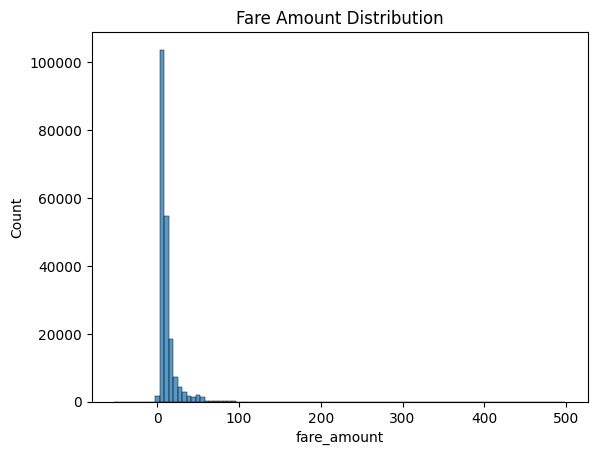

In [12]:
sns.histplot(df["fare_amount"], bins=100)
plt.title("Fare Amount Distribution")

/home/codespace/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Log Fare Distribution')

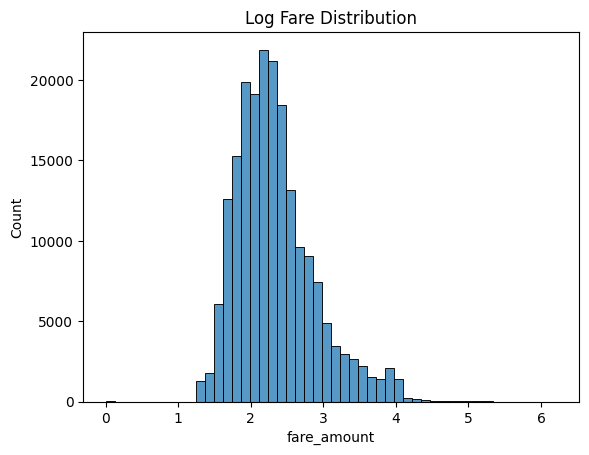

In [13]:
sns.histplot(np.log1p(df["fare_amount"]), bins=50)
plt.title("Log Fare Distribution")

In [14]:
# remove unrealistic fares
df = df[(df["fare_amount"] > 0) & (df["fare_amount"] < 200)]

### Transformation

In [15]:
# latitude/longitude ranges (NYC approx)
df = df[
    (df["pickup_latitude"].between(40, 42)) &
    (df["pickup_longitude"].between(-75, -72)) &
    (df["dropoff_latitude"].between(40, 42)) &
    (df["dropoff_longitude"].between(-75, -72))
]

In [16]:
# Parse datetime
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])

df["hour"] = df["pickup_datetime"].dt.hour
df["day_of_week"] = df["pickup_datetime"].dt.dayofweek
df["month"] = df["pickup_datetime"].dt.month
df["is_weekend"] = df["day_of_week"].isin([5,6]).astype(int)
df["is_rush_hour"] = df["hour"].isin([7,8,9,16,17,18]).astype(int)


In [17]:
# Distance (Haversine)
def haversine(lon1, lat1, lon2, lat2):
    R = 6371  # km
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

df["distance_km"] = haversine(
    df["pickup_longitude"], df["pickup_latitude"],
    df["dropoff_longitude"], df["dropoff_latitude"]
)

df = df[df["distance_km"] < 50]  # remove wild values

In [54]:
!pip install h3

In [18]:
from h3 import latlng_to_cell
# H3 location encoding
resolution = 8

df["pickup_h3"] = df.apply(
    lambda r: latlng_to_cell(r["pickup_latitude"], r["pickup_longitude"], resolution), axis=1
)

df["dropoff_h3"] = df.apply(
    lambda r: latlng_to_cell(r["dropoff_latitude"], r["dropoff_longitude"], resolution), axis=1
)

### Feature importance analysis

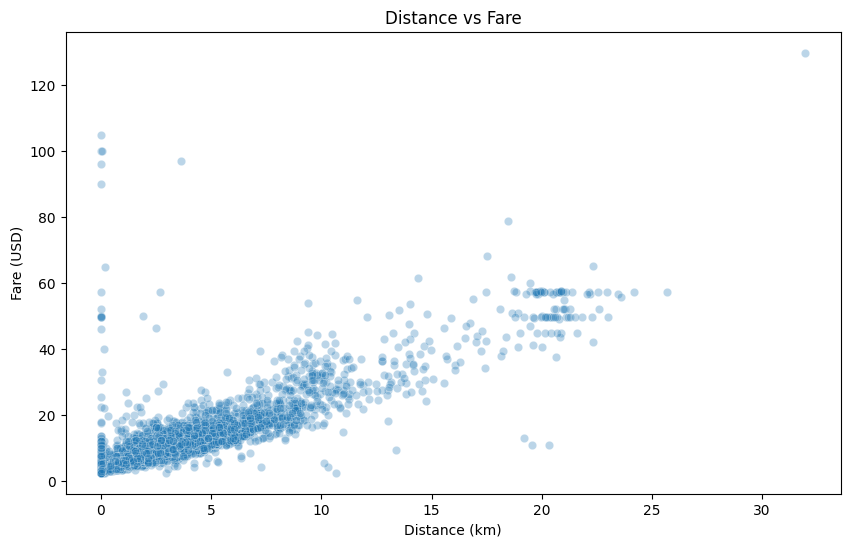

In [19]:
# Distance vs Fare (Scatterplot)

# Purpose: check whether fare increases monotonically with distance and detect outliers.

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.scatterplot(data=df.sample(5000), x="distance_km", y="fare_amount", alpha=0.3)
plt.title("Distance vs Fare")
plt.xlabel("Distance (km)")
plt.ylabel("Fare (USD)")
plt.show()


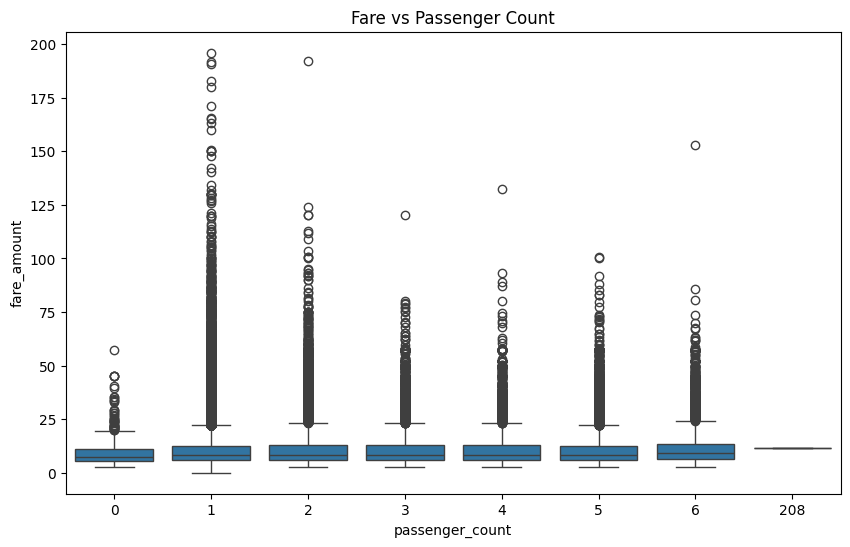

In [20]:
#A. Passenger Count vs Fare
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="passenger_count", y="fare_amount")
plt.title("Fare vs Passenger Count")
plt.show()

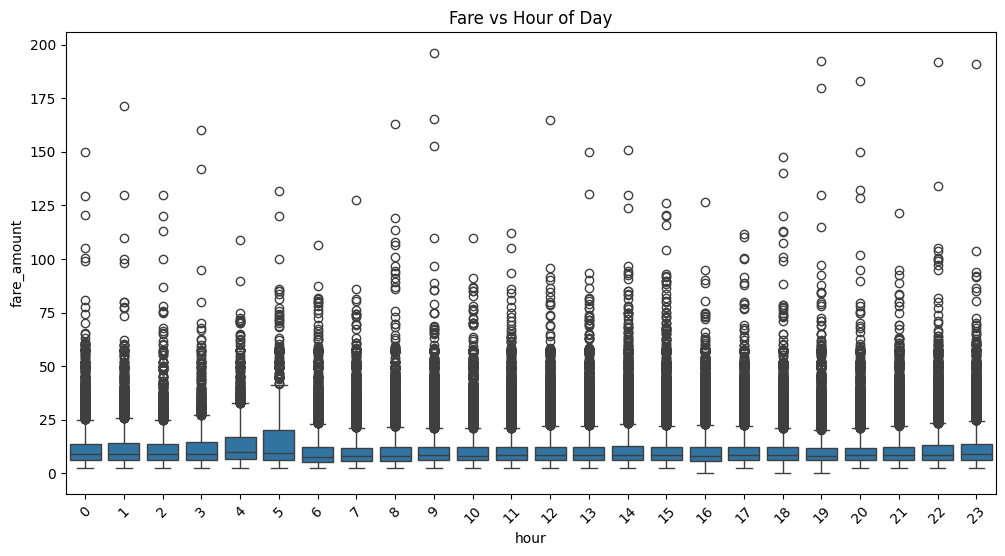

In [21]:
#B. Hour of Day vs Fare
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x="hour", y="fare_amount")
plt.xticks(rotation=45)
plt.title("Fare vs Hour of Day")
plt.show()

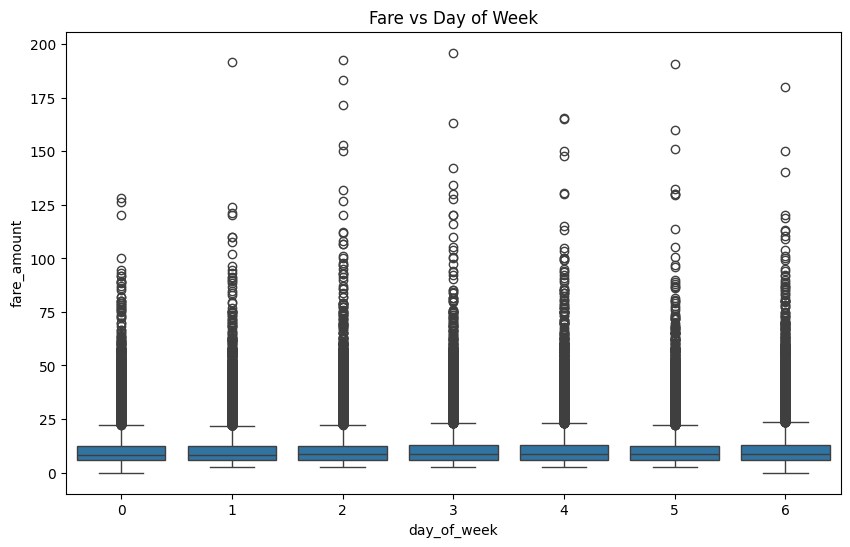

In [22]:
# Weekday vs Fare
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="day_of_week", y="fare_amount")
plt.title("Fare vs Day of Week")
plt.show()


In [23]:
# H3 Heatmap (Hexagonal Density Map)

# We'll plot pickup density grouped by H3 hexagon.

# Step 1 — Count trips per hexagon
pickup_counts = df["pickup_h3"].value_counts().reset_index()
pickup_counts.columns = ["h3", "count"]
pickup_counts.head()

,h3,count
0,882a100d2dfffff,9542
1,882a100d61fffff,9461
2,882a100d65fffff,8564
3,882a100d67fffff,7697
4,882a100d21fffff,7412


In [78]:
! pip install geopandas

In [24]:
# Convert H3 hexagons to boundaries

# H3 provides polygon boundaries for mapping.
import geopandas as gpd
from shapely.geometry import Polygon
from h3 import cell_to_boundary

def h3_to_polygon(h):
    boundary = cell_to_boundary(h)  # returns list of (lat, lon)
    boundary_lonlat = [(lng, lat) for lat, lng in boundary]
    return Polygon(boundary_lonlat)

pickup_counts["geometry"] = pickup_counts["h3"].apply(h3_to_polygon)

gdf = gpd.GeoDataFrame(pickup_counts, geometry="geometry", crs="EPSG:4326")



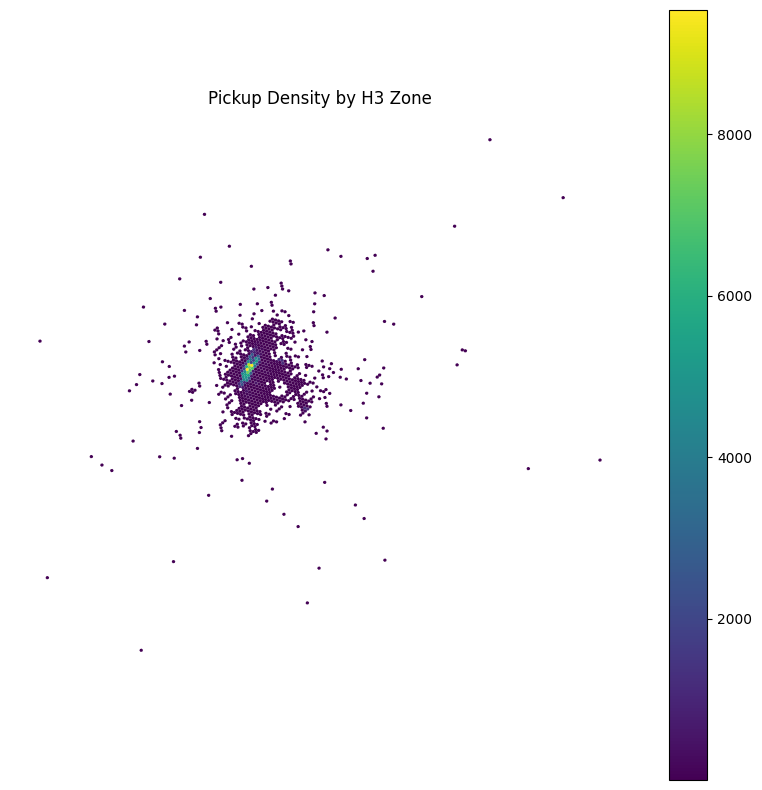

In [25]:
# Plot the heatmap
gdf.plot(column="count", cmap="viridis", figsize=(10,10), legend=True)
plt.title("Pickup Density by H3 Zone")
plt.axis("off")
plt.show()

In [26]:
cols=df.columns.tolist()
cols

['fare_amount',
 'pickup_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count',
 'hour',
 'day_of_week',
 'month',
 'is_weekend',
 'is_rush_hour',
 'distance_km',
 'pickup_h3',
 'dropoff_h3']

#### Correlation Matrix

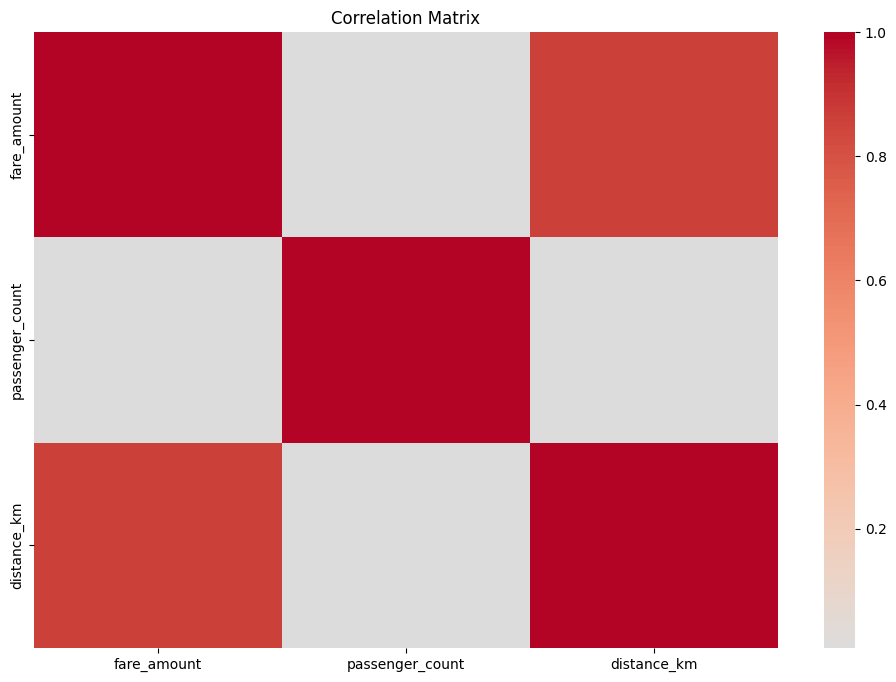

In [27]:
numeric_cols = ['fare_amount', 'passenger_count','distance_km']
corr = df[numeric_cols].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Matrix")
plt.show()

## Model selection process and parameter tuning

In [28]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression


In [29]:
features = [
    "distance_km",
    "hour",
    "day_of_week",
    "month",
    "passenger_count",
    "pickup_h3",
    "is_rush_hour",
     "dropoff_h3"
]

# X = df[features]
df["log_fare"] = np.log1p(df["fare_amount"])
# y = df["log_fare"]

In [30]:
df_full_train, df_test = train_test_split(df[[
    "distance_km",
    "hour",
    "day_of_week",
    "month",
    "passenger_count",
    "pickup_h3",
    "is_rush_hour",
     "dropoff_h3","log_fare"]], test_size=0.2, random_state=1)

df_full_train["pickup_h3_int"] = df_full_train["pickup_h3"].apply(lambda x: int(x, 16))
df_full_train["dropoff_h3_int"] = df_full_train["dropoff_h3"].apply(lambda x: int(x, 16))
df_full_train = df_full_train.drop(columns=["pickup_h3", "dropoff_h3"])

df_test["pickup_h3_int"] = df_test["pickup_h3"].apply(lambda x: int(x, 16))
df_test["dropoff_h3_int"] = df_test["dropoff_h3"].apply(lambda x: int(x, 16))
df_test = df_test.drop(columns=["pickup_h3", "dropoff_h3"])

df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_full_train=(df_full_train.log_fare).values
y_train = (df_train.log_fare).values
y_val = (df_val.log_fare).values
y_test = (df_test.log_fare).values

del df_full_train['log_fare']
del df_train['log_fare']
del df_val['log_fare']
del df_test['log_fare']

### Dummy regression

In [31]:
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor(strategy="mean")
dummy.fit(df_train, y_train)

y_pred_dummy = dummy.predict(df_val)

rmse_dummy = mean_squared_error(y_val, y_pred_dummy)
rmse = np.sqrt(rmse_dummy)

print("Dummy RMSE:", rmse)

Dummy RMSE: 0.5427751290413373


### Linear regression

In [32]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117451 entries, 0 to 117450
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   distance_km      117451 non-null  float64
 1   hour             117451 non-null  int32  
 2   day_of_week      117451 non-null  int32  
 3   month            117451 non-null  int32  
 4   passenger_count  117451 non-null  int64  
 5   is_rush_hour     117451 non-null  int64  
 6   pickup_h3_int    117451 non-null  int64  
 7   dropoff_h3_int   117451 non-null  int64  
dtypes: float64(1), int32(3), int64(4)
memory usage: 5.8 MB


In [33]:
linreg = LinearRegression()
linreg.fit(df_train, y_train)

y_val_pred = linreg.predict(df_val)

mae_lr = mean_absolute_error(y_val, y_val_pred)

rmse_lr = mean_squared_error(y_val, y_val_pred)

rmse = np.sqrt(rmse_lr)

print("Linear Regression MAE:", mae_lr)
print("Linear Regression RMSE:", rmse)

Linear Regression MAE: 0.2227712821629708
Linear Regression RMSE: 0.3049331835489087


### K-Fold Cross Validation (Robust Evaluation)

In [34]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = y_full_train[train_idx]
    y_val = y_full_train[val_idx]

    
    linreg = LinearRegression()
    linreg.fit(df_train, y_train)

    y_val_pred = linreg.predict(df_val)
    
    rmse_lr = mean_squared_error(y_val, y_val_pred)

    rmse = np.sqrt(rmse_lr)

    scores.append(rmse)
    print(rmse)
    print("-----fold----")
scores

0.3051308345029573
-----fold----
0.3023477825142536
-----fold----
0.30864055536098434
-----fold----
0.3147315221465253
-----fold----
0.3079533078031439
-----fold----


[np.float64(0.3051308345029573),
 np.float64(0.3023477825142536),
 np.float64(0.30864055536098434),
 np.float64(0.3147315221465253),
 np.float64(0.3079533078031439)]

In [35]:
std_dev = np.std(scores)
round(std_dev,4)

np.float64(0.0041)

### XGBoost Regressor (baseline)

In [36]:
!pip install xgboost

In [37]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

model = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method="hist" 
)

model.fit(df_train, y_train)

preds = model.predict(df_val)

rmse = np.sqrt(mean_squared_error(y_val, preds))

rmse

np.float64(0.2546407846343681)

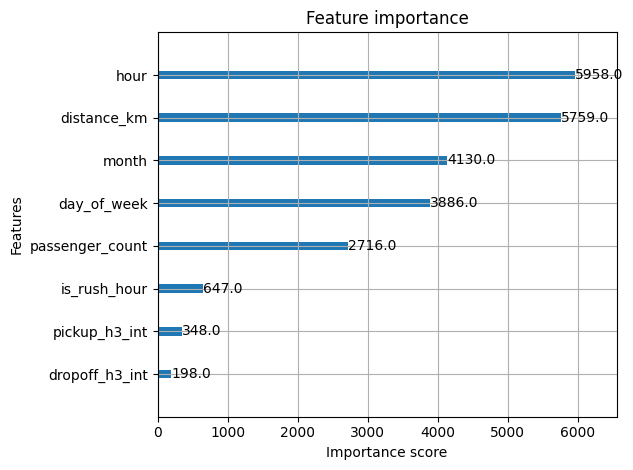

In [38]:
import xgboost as xgb
booster = model.get_booster()
booster.feature_names = list(df_train.columns)
xgb.plot_importance(booster, max_num_features=20)
plt.tight_layout()
plt.show()

## Parameter tunning

#### [max_depth and min_child_weight](https://xgboost.readthedocs.io/en/release_1.4.0/parameter.html#:~:text=of%20the%20feature-,Parameters%20for%20Tree%20Booster,min_child_weight%20%5Bdefault=1%5D)

Best params:
depth=4, mcw=1 with rmse=0.2533

In [39]:
params_grid = [
    (4, 1),
    (6, 1),
    (8, 1),
    (10, 1),
    (6, 5),
    (8, 5),
    (10, 5),
]

for max_depth, min_child_weight in params_grid:
    model = XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        random_state=42,
        tree_method="hist"
    )
    model.fit(df_train, y_train)
    preds = model.predict(df_val)
    score = np.sqrt(mean_squared_error(y_val, preds))
    print(f"depth={max_depth}, mcw={min_child_weight}, rmse={score:.4f}")

depth=4, mcw=1, rmse=0.2533
depth=6, mcw=1, rmse=0.2546
depth=8, mcw=1, rmse=0.2589
depth=10, mcw=1, rmse=0.2654
depth=6, mcw=5, rmse=0.2543
depth=8, mcw=5, rmse=0.2577
depth=10, mcw=5, rmse=0.2631


#### [n_estimators](https://xgboost.readthedocs.io/en/release_1.4.0/parameter.html#:~:text=of%20the%20feature-,Parameters%20for%20Tree%20Booster,min_child_weight%20%5Bdefault=1%5D)
Best params:
n_estimators=400 with rmse=0.25325309919096123


In [40]:
for n in [200, 400, 600, 800, 1200]:
    model = XGBRegressor(
        n_estimators=n,
        learning_rate=0.05,
        max_depth=4,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        tree_method="hist",
    )

    model.fit(df_train, y_train)
    preds = model.predict(df_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    print(n, rmse)


200 0.25327297033885254
400 0.25325309919096123
600 0.25344162110967994
800 0.253805704766663
1200 0.25423213016522916


#### [subsample and colsample_bytree](https://xgboost.readthedocs.io/en/release_1.4.0/parameter.html#:~:text=of%20the%20feature-,Parameters%20for%20Tree%20Booster,min_child_weight%20%5Bdefault=1%5D)
Best params: 
subsample=1.0, colsample_bytree=0.8 with rmse=0.25316946979891347


In [41]:
for ss in [0.6, 0.8, 1.0]:
    for cs in [0.6, 0.8, 1.0]:
        model = XGBRegressor(
            n_estimators=400,
            learning_rate=0.05,
            max_depth=4,
            min_child_weight=1,
            subsample=ss,
            colsample_bytree=cs,
            random_state=42,
            tree_method="hist",
        )
        model.fit(df_train, y_train)
        preds = model.predict(df_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        print(f"ss={ss}, cs={cs}, rmse={rmse}")


ss=0.6, cs=0.6, rmse=0.2534836229699857
ss=0.6, cs=0.8, rmse=0.25328345499425203
ss=0.6, cs=1.0, rmse=0.25348081424262914
ss=0.8, cs=0.6, rmse=0.25331474455791914
ss=0.8, cs=0.8, rmse=0.25325309919096123
ss=0.8, cs=1.0, rmse=0.25336158929062425
ss=1.0, cs=0.6, rmse=0.253250197824976
ss=1.0, cs=0.8, rmse=0.25316946979891347
ss=1.0, cs=1.0, rmse=0.253185726799594


#### [Learning rate](https://xgboost.readthedocs.io/en/release_1.4.0/parameter.html#:~:text=of%20the%20feature-,Parameters%20for%20Tree%20Booster,min_child_weight%20%5Bdefault=1%5D)
Best param:
Learning rate=0.03 with rmse=0.253217742208083

In [42]:
for lr in [0.01, 0.02, 0.03]:
    model = XGBRegressor(
        n_estimators=400,
        learning_rate=lr,
        max_depth=4,
        min_child_weight=1,
        subsample=1.0,
        colsample_bytree=0.8,
        random_state=42,
        tree_method="hist",
    )
    model.fit(df_train, y_train)
    preds = model.predict(df_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    print(f"learning rate={lr}, rmse={rmse}")

learning rate=0.01, rmse=0.2565570048074159
learning rate=0.02, rmse=0.25367051171339444
learning rate=0.03, rmse=0.253217742208083


#### Final model

In [43]:
df_test.head()

,distance_km,hour,day_of_week,month,passenger_count,is_rush_hour,pickup_h3_int,dropoff_h3_int
0,2.643110,19,2,6,1,0,613229522948456447,613229523015565311
1,5.406368,21,3,10,1,0,613229551402614783,613229524175290367
2,1.632861,7,4,2,2,1,613229524183678975,613229524179484671
3,0.791612,15,3,3,4,0,613229524246593535,613229524181581823
4,9.488742,22,6,12,1,0,613229524766687231,613229524244496383


In [44]:
model = XGBRegressor(
        n_estimators=400,
        learning_rate=0.03,
        max_depth=4,
        min_child_weight=1,
        subsample=1.0,
        colsample_bytree=0.8,
        random_state=42,
        tree_method="hist",
    )
model.fit(df_full_train, y_full_train)
preds = model.predict(df_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"rmse={rmse}")

rmse=0.25157231891988385
